# Data

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import sys
import os
current_dir = os.path.dirname(os.path.abspath("__file__"))
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
if parent_dir not in sys.path:
	sys.path.insert(0, parent_dir)
from src.models.single_pressure.variable_diffusivity_fvt import FVTModel
from src.models.single_pressure.variable_diffusivity_fvt.workflow import manual_workflow
from src.utils.data_processing import preprocess_data
from src.utils.optimisation import OptimisationCallback

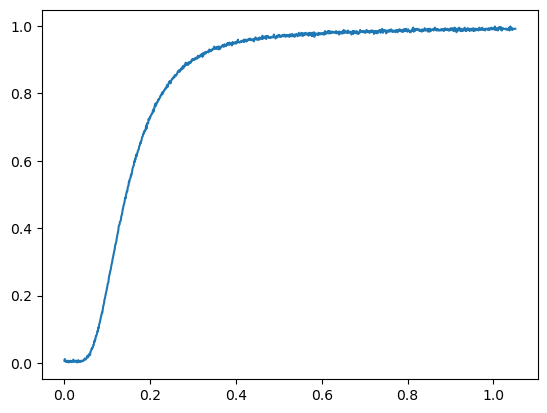

In [2]:
# Load experimental data
data_path = '../data/single_pressure/RUN_H_25C-50bar.xlsx'
exp_data = pd.read_excel(data_path)

model = FVTModel.from_parameters(
        pressure=50,
        temperature=25,
        thickness=0.1,
        diameter=1.0,
        flowrate=8.0,
        DT_0=2.38e-7,
        D1_prime=1.0,   # placeholder
    )
# Preprocess data and calculate tau
processed_exp_data = preprocess_data(
    exp_data,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    temp_celsius=model.params.base.temperature,
    truncate_at_stabilisation=True,
)

# Create 'tau' column
processed_exp_data['tau'] = model.params.transport.DT_0 * processed_exp_data['time'] / model.params.transport.thickness**2

# Downsample to 1000 points for faster optimization
if len(processed_exp_data) > 1000:
    n = len(processed_exp_data) // 1000
    processed_exp_data = processed_exp_data.iloc[::n].reset_index(drop=True)

plt.plot(processed_exp_data['tau'], processed_exp_data['normalised_flux'])
plt.show()

# Methods

## L-BFGS-B

In [25]:
def fit_data_LBFGSB(data, initial_guess=5.0, bounds=(1.01, 100)):
    # Store last objective value for callback
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime = params
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        
        # Interpolate model norm flux to data time points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux)**2))
        last_rmse[0] = rmse
        
        return rmse
    
    # Initial guess from current parameters (optimizing D1_prime only; DT_0 remains fixed)
    x0 = [initial_guess]
    bounds = [bounds]
    
    # Optimize
    result = minimize(
        lambda x: objective(x[0]),
        x0=x0,
        method='L-BFGS-B',
        bounds=bounds,
        callback=None,
    )
    
    # Print results
    print(f"Optimization result: {result}")   
    
    return result.x[0], last_rmse[0]

In [26]:
fit_results = fit_data_LBFGSB(processed_exp_data, initial_guess=5.0, bounds=(1.01, 100))
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results[0],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)


Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07):   0%|                       | 0/44160.0 [00:00<?, ?it/s]

Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 25934.05it/s]              
Adaptive PDE Solve (D1'=5.00000001, DTO=2.38e-07): 44162.868114456105it [00:01, 27896.60it/s]       
Adaptive PDE Solve (D1'=4.98018960350072, DTO=2.38e-07): 44167.8586819049it [00:01, 27910.97it/s]   
Adaptive PDE Solve (D1'=4.98018961350072, DTO=2.38e-07):  25%|▎| 11159.554674475145/44160.0 [00:01<0

KeyboardInterrupt: 

## L-BFGS-B with multi-start

In [31]:
def fit_data_LBFGSB_multistarts(data, initial_guess=5.0, bounds=(1.01, 100), n_starts=5):
    """
    Multi-start optimization for fitting D1_prime using L-BFGS-B.
    
    Parameters:
      data : dict
          Experimental data with keys 'time', 'tau', and 'norm_flux'.
      initial_guess : float
          Default initial value for D1_prime.
      bounds : tuple
          Lower and upper bound for D1_prime.
      n_starts : int
          Number of starting points to try.
    
    Returns:
      best_params : dict
          Dictionary containing the best fit parameters and RMSE.
          Example: {'D1_prime': value, 'rmse': value, 'optimisation_result': result}
    """
    best_result = None
    best_fun = np.inf
    best_rmse = np.inf

    def objective(params):
        D1_prime = params
        # Assuming 'model' is accessible from the current context
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        # Interpolate model normalized flux to data tau points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
        return rmse

    # Prepare bounds in required format: [(low, high)]
    bounds_list = [bounds]
    
    for i in range(n_starts):
        # Use the provided initial guess for the first start; for subsequent starts use a random candidate within bounds.
        if i == 0:
            x0 = [initial_guess]
        else:
            low, high = bounds
            candidate = np.random.uniform(low, high)
            x0 = [candidate]
        result = minimize(
            lambda x: objective(x[0]),
            x0=x0,
            method='L-BFGS-B',
            bounds=bounds_list,
            callback=None
        )
        if result.fun < best_fun:
            best_fun = result.fun
            best_result = result
            best_rmse = result.fun
    
    print(f"Best optimization result: {best_result}")
    best_params = {
        'D1_prime': best_result.x[0],
        'rmse': best_rmse,
        'optimisation_result': best_result
    }
    return best_params


















Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 27734.35it/s]              
















Adaptive PDE Solve (D1'=5.00000001, DTO=2.38e-07): 44162.868114456105it [00:01, 25329.35it/s]       
















Adaptive PDE Solve (D1'=4.98018960350072, DTO=2.38e-07): 44167.8586819049it [00:01, 28022.48it/s]   
















Adaptive PDE Solve (D1'=4.98018961350072, DTO=2.38e-07): 44167.8586819049it [00:01, 27934.53it/s]   
















Adaptive PDE Solve (D1'=4.960304815119444, DTO=2.38e-07): 44169.452646729886it [00:01, 27784.08it/s]
















Adaptive PDE Solve (D1'=4.960304825119444, DTO=2.38e-07): 44169.452646729886it [00:01, 27756.20it/s]
















Adaptive PDE Solve (D1'=4.8807656615943396, DTO=2.38e-07): 44161.59198703404it [00:01, 25652.47it/s]
















Adaptive PDE Solve (D1'=4.8807656715943395, DTO=2.38e-07): 44161.59198703404it [00:01, 28519.34it/s]















Adaptive PDE Solve (D1'=4.562609047493923, DTO=2.

Best optimization result:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.015090566244238914
        x: [ 1.183e+00]
      nit: 6
      jac: [-5.176e-03]
     nfev: 114
     njev: 57
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>








Adaptive PDE Solve (D1'=1.1833057810305825, DTO=2.38e-07): 44169.15560370677it [00:00, 84018.24it/s]
Adaptive PDE Solve (D1'=4.98018961350072, DTO=2.38e-07):  29%|▎| 12747.06445555994/44160.0 [22:34<55


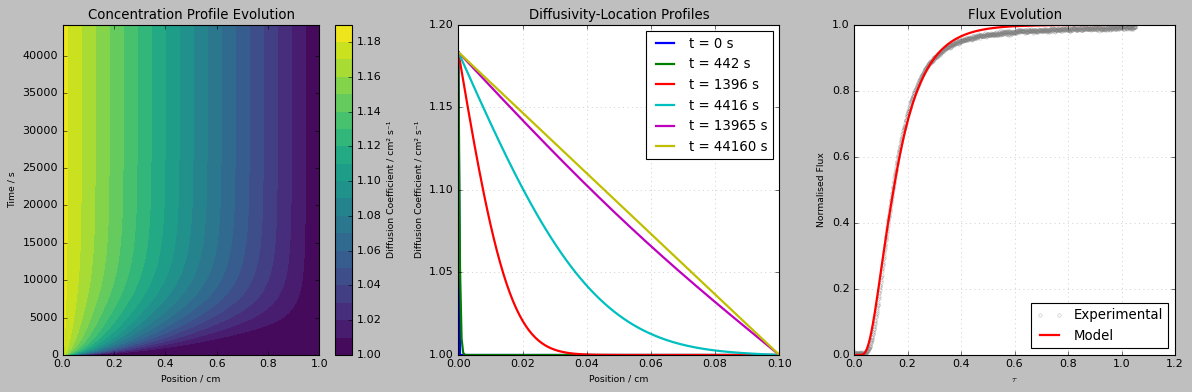

In [33]:
# Example usage:
fit_results = fit_data_LBFGSB_multistarts(processed_exp_data, initial_guess=5.0, bounds=(1.001, 100), n_starts=3)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)


## L-BFGS-B with multi-start and callback

### D1'

In [9]:
def fit_data_LBFGSB_multistarts_callback(data, initial_guess=5.0, bounds=(1.01, 100), n_starts=1):
    """
    Multi-start optimization for fitting D1_prime using L-BFGS-B.
    
    Parameters:
      data : dict
          Experimental data with keys 'time', 'tau', and 'norm_flux'.
      initial_guess : float
          Default initial value for D1_prime.
      bounds : tuple
          Lower and upper bound for D1_prime.
      n_starts : int
          Number of starting points to try.
    
    Returns:
      best_params : dict
          Dictionary containing the best fit parameters and RMSE.
          Example: {'D1_prime': value, 'rmse': value, 'optimisation_result': result}
    """
    # Validate that n_starts is an integer greater than or equal to 1
    if not isinstance(n_starts, int) or n_starts < 1:
        raise ValueError("n_starts must be an integer greater than or equal to 1")
    
    best_result = None
    best_fun = np.inf
    best_rmse = np.inf

    # Create a common callback instance (it will collect history over all multi-start runs)
    callback_instance = OptimisationCallback(param_names=["D1_prime"])
    
    # Global variable to hold the last RMSE calculated by objective
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime = params
        # Assuming 'model' is accessible from the current context
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        # Interpolate model normalized flux to data tau points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
        last_rmse[0] = rmse
        return rmse

    # Prepare bounds in required format: [(low, high)]
    bounds_list = [bounds]
    
    for i in range(n_starts):
        # Use the provided initial guess for the first start; for subsequent starts use a random candidate within bounds.
        if i == 0:
            x0 = [initial_guess]
        else:
            low, high = bounds
            candidate = np.random.uniform(low, high)
            x0 = [candidate]
        
            # Define a local callback that sends the current parameter vector and last RMSE to our callback_instance.
        def local_callback(xk):
            # SciPy's callback receives xk only.
            # Pass current xk and the last computed rmse.
            callback_instance(xk, last_rmse[0])
        
        # Run minimization with L-BFGS-B for this starting point
        result = minimize(
            lambda x: objective(x[0]),
            x0=x0,
            method='L-BFGS-B',
            bounds=bounds_list,
            callback=local_callback
        )
        
        if result.fun < best_fun:
            best_fun = result.fun
            best_result = result
            best_rmse = result.fun
    
    callback_instance.close()

    best_params = {
        'D1_prime': best_result.x[0],
        'rmse': best_rmse,
        'optimisation_result': best_result,
        'optimisation_history': callback_instance.history
    }
    print(f"Best optimization result: {best_result}")
    
    return best_params

Fitting (multi-start): 0iter [00:00, ?iter/s]



































Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 24006.38it/s]              
































Adaptive PDE Solve (D1'=5.00000001, DTO=2.38e-07): 44162.868114456105it [00:01, 26958.51it/s]       
































Adaptive PDE Solve (D1'=4.98018960350072, DTO=2.38e-07): 44167.8586819049it [00:01, 27356.06it/s]   
































Adaptive PDE Solve (D1'=4.98018961350072, DTO=2.38e-07): 44167.8586819049it [00:01, 27273.20it/s]   




































Adaptive PDE Solve (D1'=4.960304815119444, DTO=2.38e-07): 44169.452646729886it [00:01, 24402.01it/s]
































Adaptive PDE Solve (D1'=4.960304825119444, DTO=2.38e-07): 44169.452646729886it [00:01, 27264.34it/s]


































Adaptive PDE Solve (D1'=4.8807656615943396, DTO=2.38e-07): 44161.59198703404it [00:01, 26940.68it/s]




































Adaptive PDE Solve (D1'=4

Best optimization result:   message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.016199273396428154
        x: [ 1.277e+00]
      nit: 5
      jac: [-6.793e-04]
     nfev: 88
     njev: 44
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>









Adaptive PDE Solve (D1'=1.2769096905924737, DTO=2.38e-07): 44165.686060797234it [00:00, 69385.43it/s]


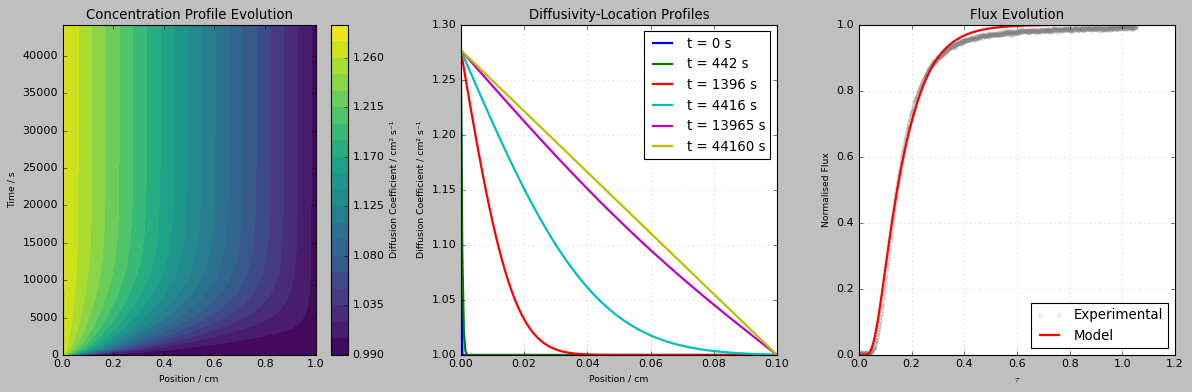

In [11]:
# Example usage:
fit_results = fit_data_LBFGSB_multistarts_callback(processed_exp_data, initial_guess=5.0, bounds=(1.001, 20), n_starts=1)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)

### D1' and DT0

In [3]:
def fit_data_LBFGSB_multistarts_callback_2(data, initial_guess=5.0, bounds=(1.01, 100), n_starts=1):
    """
    Multi-start optimization for fitting D1_prime and DT_0 using L-BFGS-B with callback tracking.
    
    Parameters:
      data : dict
          Experimental data with keys 'time', 'tau', and 'norm_flux'.
      initial_guess : tuple of floats
          Default initial values for (D1_prime, DT_0).
      bounds : tuple of tuples
          Bounds for D1_prime and DT_0, e.g. ((low_D1, high_D1), (low_DT0, high_DT0)).
      n_starts : int
          Number of starting points to try.
    
    Returns:
      best_params : dict
          Dictionary containing the best-fit parameters, RMSE, the full optimization result,
          and the callback history.
          Example: {'D1_prime': value, 'DT_0': value, 'rmse': value, ... }
    """
    # Validate that n_starts is an integer greater than or equal to 1
    if not isinstance(n_starts, int) or n_starts < 1:
        raise ValueError("n_starts must be an integer greater than or equal to 1")
    
    best_result = None
    best_fun = np.inf
    best_rmse = np.inf

    # Create a common callback instance (it will collect history over all multi-start runs)
    callback_instance = OptimisationCallback(param_names=["D1_prime", "DT_0"])
    
    # Global variable to hold the last RMSE calculated by objective
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime, DT_0 = params
        # Assuming 'model' is accessible from the current context
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        # Interpolate model normalized flux to data tau points
        model_norm_flux = np.interp(data['time'], flux_df['time'], flux_df['normalised_flux'])
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux) ** 2))
        last_rmse[0] = rmse
        return rmse

    # Prepare bounds in required format: a list of tuples
    bounds_list = list(bounds)
    
    for i in range(n_starts):
        # Use the provided initial guess for the first start; for subsequent starts use a random candidate within bounds.
        if i == 0:
            x0 = list(initial_guess)    # list
        else:
            candidate = [np.random.uniform(low, high) for (low, high) in bounds_list]
            x0 = candidate  # list
        
            # Define a local callback that sends the current parameter vector and last RMSE to our callback_instance.
        def local_callback(xk):
            # SciPy's callback receives xk only.
            # Pass current xk and the last computed rmse.
            callback_instance(xk, last_rmse[0])
        
        # Run minimization with L-BFGS-B for this starting point
        result = minimize(
            lambda x: objective(x),
            x0=x0,
            method='L-BFGS-B',
            bounds=bounds_list,
            callback=local_callback
        )
        
        if result.fun < best_fun:
            best_fun = result.fun
            best_result = result
            best_rmse = result.fun
    
    callback_instance.close()

    best_params = {
        'D1_prime': best_result.x[0],
        'DT_0': best_result.x[1],
        'rmse': best_rmse,
        'optimisation_result': best_result,
        'optimisation_history': callback_instance.history
    }
    print(f"Best optimization result:")
    print(best_params)
    
    return best_params

Fitting (multi-start): 0iter [00:00, ?iter/s]

Adaptive PDE Solve (D1'=5.0, DTO=1e-07): 44162.46753516588it [00:02, 21904.34it/s]                  
Adaptive PDE Solve (D1'=5.00000001, DTO=1e-07): 44162.46753516588it [00:01, 29486.03it/s]           
Adaptive PDE Solve (D1'=5.0, DTO=1.0999999999999999e-07): 44161.439383547404it [00:01, 33367.26it/s]
Adaptive PDE Solve (D1'=5.0003771390195215, DTO=1e-06): 44167.10994145788it [00:02, 21008.25it/s]   
Adaptive PDE Solve (D1'=5.0003771490195215, DTO=1e-06): 44167.10994145788it [00:02, 21077.95it/s]   
Adaptive PDE Solve (D1'=5.0003771390195215, DTO=9.9e-07): 44163.42094283127it [00:02, 19379.10it/s] 
Adaptive PDE Solve (D1'=5.000114192362101, DTO=3.7250727336906417e-07): 44163.12779886047it [00:01, 25082.48it/s]
Adaptive PDE Solve (D1'=5.000114202362101, DTO=3.7250727336906417e-07): 44163.12779886047it [00:01, 25649.01it/s]
Adaptive PDE Solve (D1'=5.000114192362101, DTO=3.825072733690642e-07): 44165.10094524713it [00:01, 23048.71it/s]
Adaptive PDE Solve (D1'=5.000035073911279, DTO=1.8369

Best optimization result:
{'D1_prime': 5.000021748440508, 'DT_0': 1.5190032291492153e-07, 'rmse': 0.027295479597978643, 'optimisation_result':   message: ABNORMAL_TERMINATION_IN_LNSRCH
  success: False
   status: 2
      fun: 0.027295479597978643
        x: [ 5.000e+00  1.519e-07]
      nit: 4
      jac: [ 3.473e-03  5.377e+05]
     nfev: 150
     njev: 50
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>, 'optimisation_history': [{'iteration': 0, 'D1_prime': 5.000035073911279, 'DT_0': 1.8369995815290932e-07, 'rmse': 0.07190859568381006}, {'iteration': 1, 'D1_prime': 5.000025066929934, 'DT_0': 1.5981956997041408e-07, 'rmse': 0.04158350174993429}, {'iteration': 2, 'D1_prime': 5.00002258960002, 'DT_0': 1.5390767150203558e-07, 'rmse': 0.03471559684645483}, {'iteration': 3, 'D1_prime': 5.000021748440508, 'DT_0': 1.5190032291492153e-07, 'rmse': 0.03267259966675512}]}


Adaptive PDE Solve (D1'=5.000021748440508, DTO=1.5190032291492153e-07): 44167.24540316226it [00:01, 31415.45it/s]


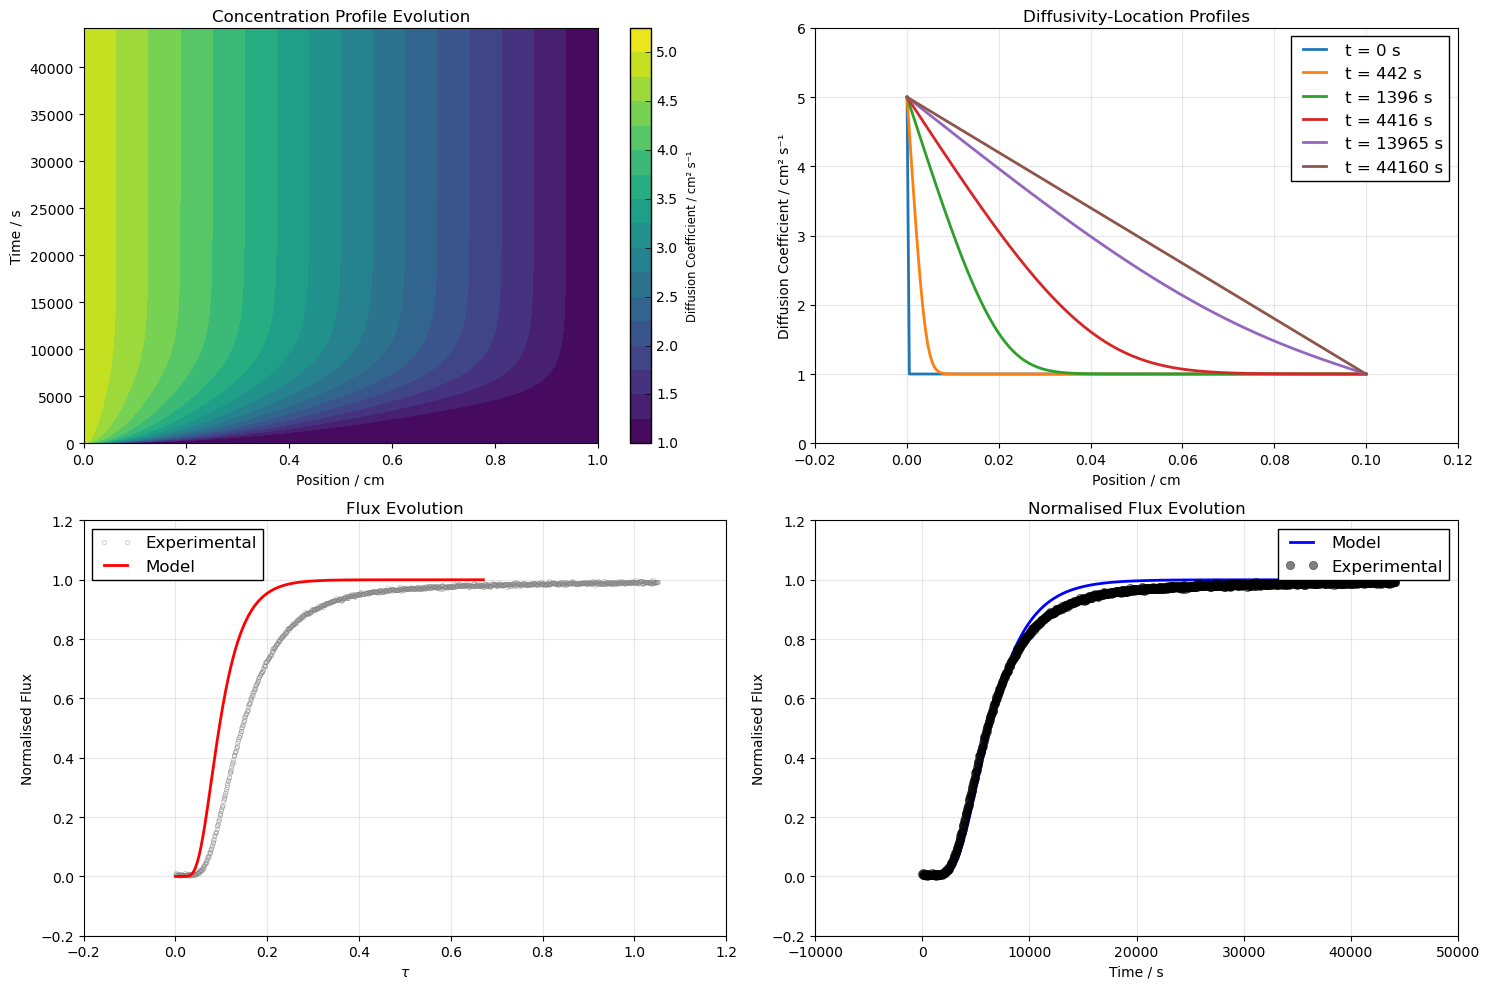

In [4]:
# Example usage:
fit_results = fit_data_LBFGSB_multistarts_callback_2(processed_exp_data, 
                                                     initial_guess=(5.0, 1.0e-7), 
                                                     bounds=((1.001, 20), (1e-8, 1e-6)), 
                                                     n_starts=1)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results['D1_prime'],
    DT_0=fit_results['DT_0'],
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)

## Nelder-Mead

In [10]:
def fit_data_Nelder_Mead(data, initial_guess=5.0):
    # Store last objective value for callback
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime = params
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        
        # Interpolate model norm flux to data time points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux)**2))
        last_rmse[0] = rmse
        
        return rmse
    
    # Initial guess from current parameters (optimizing D1_prime only; DT_0 remains fixed)
    x0 = [initial_guess]
    
    # Optimize
    result = minimize(
        lambda x: objective(x[0]),
        x0=x0,
        method='Nelder-Mead',
        callback=None,
    )
    
    # Print results
    print(f"Optimization result: {result}")   
    
    return result.x[0], last_rmse[0]

Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 26112.38it/s]              
Adaptive PDE Solve (D1'=5.25, DTO=2.38e-07): 44169.52141970966it [00:01, 27363.13it/s]              
Adaptive PDE Solve (D1'=4.75, DTO=2.38e-07): 44168.5685931025it [00:01, 28620.62it/s]               
Adaptive PDE Solve (D1'=4.5, DTO=2.38e-07):  45%|▍| 19680.29146525265/44160.0 [00:01<00:00, 25043.12c:\Users\sieun\anaconda3\envs\permeationenv\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Adaptive PDE Solve (D1'=4.5, DTO=2.38e-07): 100%|█| 44160.29146525265/44160.0 [00:01<00:00, 29629.41
Adaptive PDE Solve (D1'=4.0, DTO=2.38e-07): 44168.50037209686it [00:01, 31444.48it/s]               
Adaptive PDE Solve (D1'=3.5, DTO=2.38e-07): 44168.13597441362it [00:01, 34042.79it/s]               
Adaptive PDE Solve (D1'=2.5, DTO=2.38e-07): 44163.56795598284it [00:01, 41615.73it/s]               
Adaptive PDE Solve (D1'=1.5, DTO=2.38e-07): 4416

Optimization result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.013637090023115545
             x: [ 1.125e+00]
           nit: 22
          nfev: 47
 final_simplex: (array([[ 1.125e+00],
                       [ 1.125e+00]]), array([ 1.364e-02,  1.364e-02]))


Adaptive PDE Solve (D1'=1.124755859375, DTO=2.38e-07): 44163.186486462466it [00:00, 93449.60it/s]   


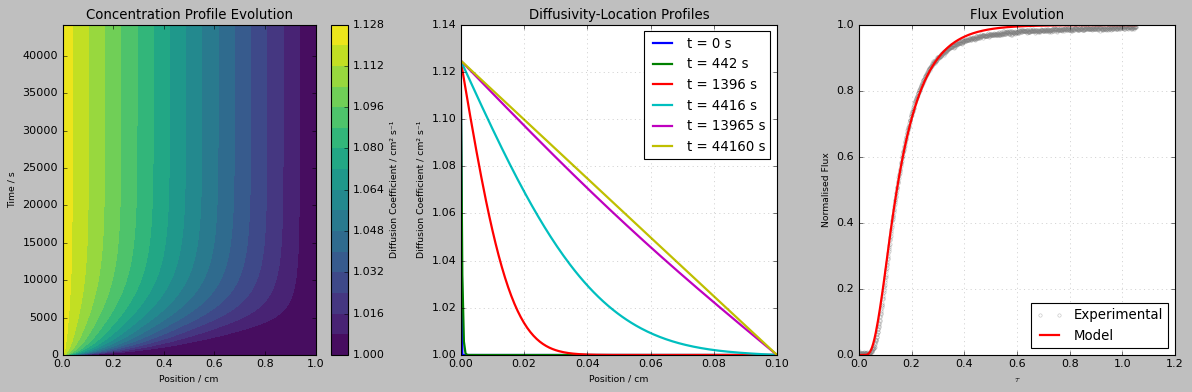

In [11]:
fit_results = fit_data_Nelder_Mead(processed_exp_data, initial_guess=5.0)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results[0],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)


## BFGS

In [12]:
def fit_data_BFGS(data, initial_guess=5.0):
    # Store last objective value for callback
    last_rmse = [float('inf')]
    
    def objective(params):
        D1_prime = params
        _, flux_df = model._solve_pde(
            L=model.params.transport.thickness,
            D1_prime=D1_prime,
            DT_0=model.params.transport.DT_0,
            T=data['time'].max(),
            X=1.0,
            dx=0.005,
        )
        
        # Interpolate model norm flux to data time points
        model_norm_flux = np.interp(data['tau'], flux_df['tau'], flux_df['normalised_flux'])
        
        # Calculate RMSE
        rmse = np.sqrt(np.mean((data['normalised_flux'] - model_norm_flux)**2))
        last_rmse[0] = rmse
        
        return rmse
    
    # Initial guess from current parameters (optimizing D1_prime only; DT_0 remains fixed)
    x0 = [initial_guess]
    
    # Optimize
    result = minimize(
        lambda x: objective(x[0]),
        x0=x0,
        method='Nelder-Mead',
        callback=None,
    )
    
    # Print results
    print(f"Optimization result: {result}")   
    
    return result.x[0], last_rmse[0]

Adaptive PDE Solve (D1'=5.0, DTO=2.38e-07): 44162.868114456105it [00:01, 27806.98it/s]              
Adaptive PDE Solve (D1'=5.25, DTO=2.38e-07): 44169.52141970966it [00:01, 25754.86it/s]              
Adaptive PDE Solve (D1'=4.75, DTO=2.38e-07): 44168.5685931025it [00:01, 28691.57it/s]               
Adaptive PDE Solve (D1'=4.5, DTO=2.38e-07):  37%|▎| 16523.61202475265/44160.0 [00:01<00:01, 18432.30c:\Users\sieun\anaconda3\envs\permeationenv\Lib\site-packages\tqdm\std.py:636: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
Adaptive PDE Solve (D1'=4.5, DTO=2.38e-07): 100%|█| 44160.29146525265/44160.0 [00:01<00:00, 29645.96
Adaptive PDE Solve (D1'=4.0, DTO=2.38e-07): 44168.50037209686it [00:01, 31344.69it/s]               
Adaptive PDE Solve (D1'=3.5, DTO=2.38e-07): 44168.13597441362it [00:01, 33977.07it/s]               
Adaptive PDE Solve (D1'=2.5, DTO=2.38e-07): 44163.56795598284it [00:01, 41277.23it/s]               
Adaptive PDE Solve (D1'=1.5, DTO=2.38e-07): 4416

Optimization result:        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 0.013637090023115545
             x: [ 1.125e+00]
           nit: 22
          nfev: 47
 final_simplex: (array([[ 1.125e+00],
                       [ 1.125e+00]]), array([ 1.364e-02,  1.364e-02]))


Adaptive PDE Solve (D1'=1.124755859375, DTO=2.38e-07): 44163.186486462466it [00:00, 93727.30it/s]   


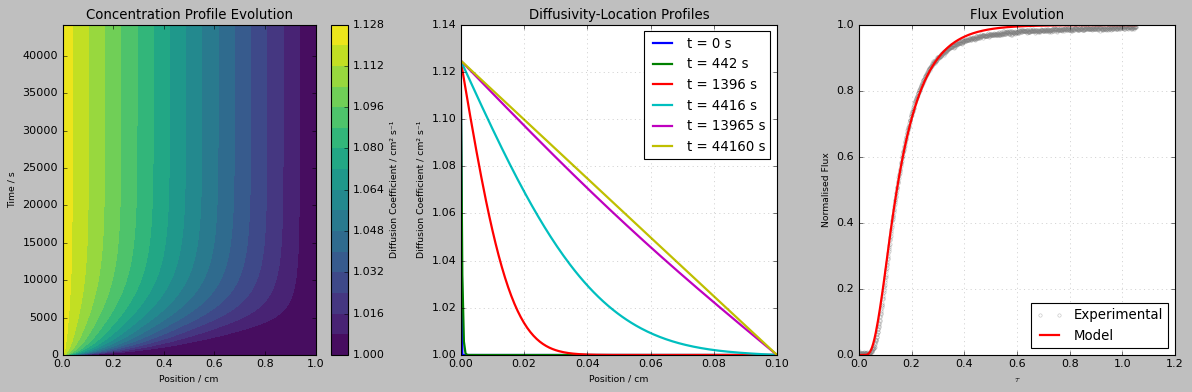

In [13]:
fit_results = fit_data_BFGS(processed_exp_data, initial_guess=5.0)
model, Dprime_df, flux_df, figures = manual_workflow(
    pressure=model.params.base.pressure,
    temperature=model.params.base.temperature,
    thickness=model.params.transport.thickness,
    diameter=model.params.transport.diameter,
    flowrate=model.params.transport.flowrate,
    D1_prime=fit_results[0],
    DT_0=model.params.transport.DT_0,
    experimental_data=processed_exp_data,
    simulation_params={
        'T': processed_exp_data['time'].max(),
        'X': 1.0,
        'dx': 0.005,
        },
    output_settings={
            'output_dir': 'outputs/fitting',
            'display_plots': True,
            'save_plots': False,
            'save_data': False,
            'plot_format': 'png',
            'data_format': 'csv'
    }
)